### setup

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '../src/')
from video_tools import *
from image_tools import *
from notebook_tools import *

In [3]:
%load_ext autoreload
%autoreload 1
%aimport video_tools
%aimport image_tools
%aimport notebook_tools

In [4]:
# normal size plots
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)

In [5]:
video = '../vid_out/Game_20210407T150943.avi'

In [6]:
mask = np.load('./manual_mask.npy')

In [7]:
def find_and_draw_keypoints(img):
    masked = apply_mask(img, mask)
    pts = find_keypoints(masked)
    return draw_pts(masked, pts)

### showcasing many images

In [8]:
trim(200, 260, video, '../vid_out/clip.avi')

In [9]:
clip = '../vid_out/clip.avi'

In [10]:
filter_playback(clip, lambda x:x, interval_ms=1000)

### possible structure for tracking keypoints:
```
keypoint (aka feature) = {
    x,y,
    patch,
    descriptor,
    (frame_num and neighbors for context?)
}

frame = {
    keypoints[],
    num
}
```

In [11]:
frame_collection = []
def on_frame(img):
    masked = apply_mask(img, mask)
    pts = find_keypoints(masked)
    patches = [patch_at(masked, pt) for pt in pts]
    keypoints = [{
        'pt': pt,
        'patch': patch,
    } for pt, patch in zip(pts, patches)]
    frame_collection.append(keypoints)
    masked_around = mask_patches_around_pts(masked, pts)
    return draw_pts(masked_around, pts)

In [12]:
filter_playback(clip, resize_wrapper(on_frame))

In [13]:
for keypoints in frame_collection[:2]:
    print(len(keypoints))
    for kp in keypoints:
        print(kp['pt'])


16
(60, 31)
(21, 30)
(52, 18)
(33, 5)
(2, 31)
(16, 47)
(32, 56)
(40, 45)
(1, 47)
(28, 17)
(16, 57)
(51, 57)
(68, 58)
(52, 39)
(34, 25)
(6, 56)
17
(59, 31)
(20, 30)
(34, 5)
(51, 18)
(16, 47)
(39, 44)
(32, 56)
(2, 31)
(1, 47)
(16, 57)
(28, 17)
(50, 57)
(67, 57)
(50, 39)
(38, 21)
(6, 56)
(35, 33)


In [14]:
kpsA, kpsB = frame_collection[:2]
ptsA = np.array([kp['pt'] for kp in kpsA])
ptsB = np.array([kp['pt'] for kp in kpsB])

In [15]:
def nearest_pts_indexes(pt, other_pts):
    xydiffs = np.subtract(other_pts, pt)
    sq_diffs = xydiffs * xydiffs
    sq_dists = sq_diffs.sum(1)
    index_arr = sq_dists.argsort()
    return index_arr

In [16]:
def nearest_pts(pt, other_pts):
    index_arr = nearest_pts_indexes(pt, other_pts)
    return other_pts[index_arr]

In [17]:
for pt in ptsB:
    neighbors = nearest_pts(pt, ptsA)
    print(pt, tuple(neighbors[:2]) )

[59 31] (array([60, 31], dtype=int32), array([52, 39], dtype=int32))
[20 30] (array([21, 30], dtype=int32), array([34, 25], dtype=int32))
[34  5] (array([33,  5], dtype=int32), array([28, 17], dtype=int32))
[51 18] (array([52, 18], dtype=int32), array([60, 31], dtype=int32))
[16 47] (array([16, 47], dtype=int32), array([16, 57], dtype=int32))
[39 44] (array([40, 45], dtype=int32), array([32, 56], dtype=int32))
[32 56] (array([32, 56], dtype=int32), array([40, 45], dtype=int32))
[ 2 31] (array([ 2, 31], dtype=int32), array([ 1, 47], dtype=int32))
[ 1 47] (array([ 1, 47], dtype=int32), array([ 6, 56], dtype=int32))
[16 57] (array([16, 57], dtype=int32), array([16, 47], dtype=int32))
[28 17] (array([28, 17], dtype=int32), array([34, 25], dtype=int32))
[50 57] (array([51, 57], dtype=int32), array([40, 45], dtype=int32))
[67 57] (array([68, 58], dtype=int32), array([51, 57], dtype=int32))
[50 39] (array([52, 39], dtype=int32), array([40, 45], dtype=int32))
[38 21] (array([34, 25], dtype=int

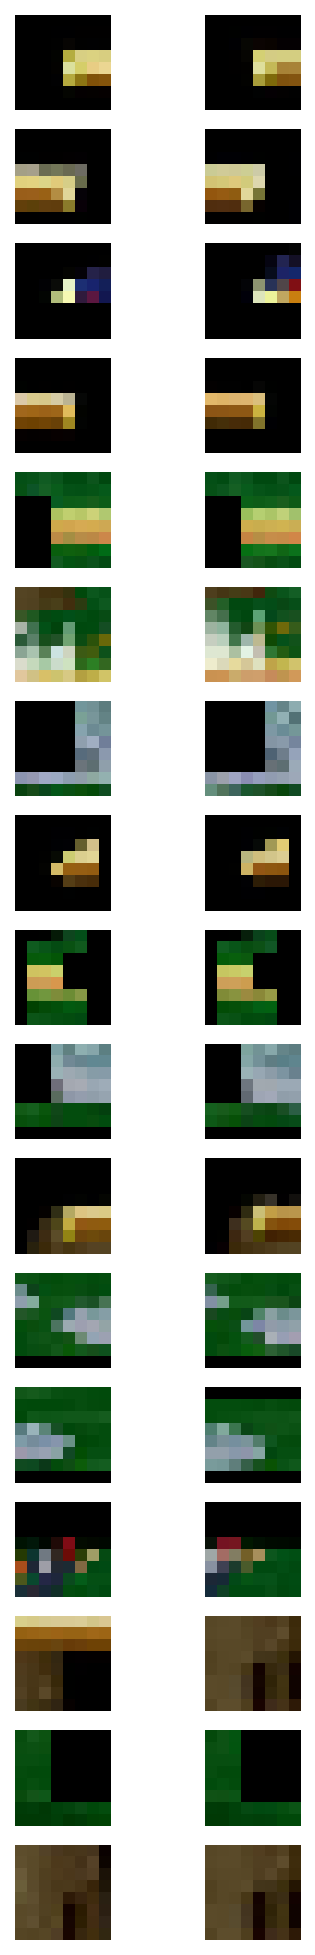

In [18]:
ptsA = [kp['pt'] for kp in kpsA]
images = []
for kp in kpsB:
    pt = kp['pt']
    i = nearest_pts_indexes(pt, ptsA)[0]
    patchB = kp['patch']
    patchA = kpsA[i]['patch']
    images.extend((patchB, patchA))
    
plt.rcParams['figure.figsize'] = (3, len(kpsB))
plot_a_lot(images, imshow_bgr2rgb, nrows=len(kpsB))

In [19]:
def get_keypoints(img):
    # returns list of {pt, patch}
    pts = find_keypoints(img)
    patches = [patch_at(img, pt) for pt in pts]
    keypoints = [{
        'pt': pt,
        'patch': patch,
    } for pt, patch in zip(pts, patches)]
    return keypoints

In [20]:
def compare_frames(imgA, imgB):
    kpsA = get_keypoints(imgA)
    kpsB = get_keypoints(imgB)
    
    ptsA = [kp['pt'] for kp in kpsA]
    images = []
    for kp in kpsB:
        pt = kp['pt']
        i = nearest_pts_indexes(pt, ptsA)[0]
        patchB = kp['patch']
        patchA = kpsA[i]['patch']
        images.extend((patchB, patchA, blur(patchA)))

    plt.rcParams['figure.figsize'] = (3, len(kpsB))
    plot_a_lot(images, imshow_bgr2rgb, nrows=len(kpsB))

In [21]:
def downscale_and_mask(raw_frame):
    small = downscale_max_to_min_res(raw_frame)
    return apply_mask(small, mask)

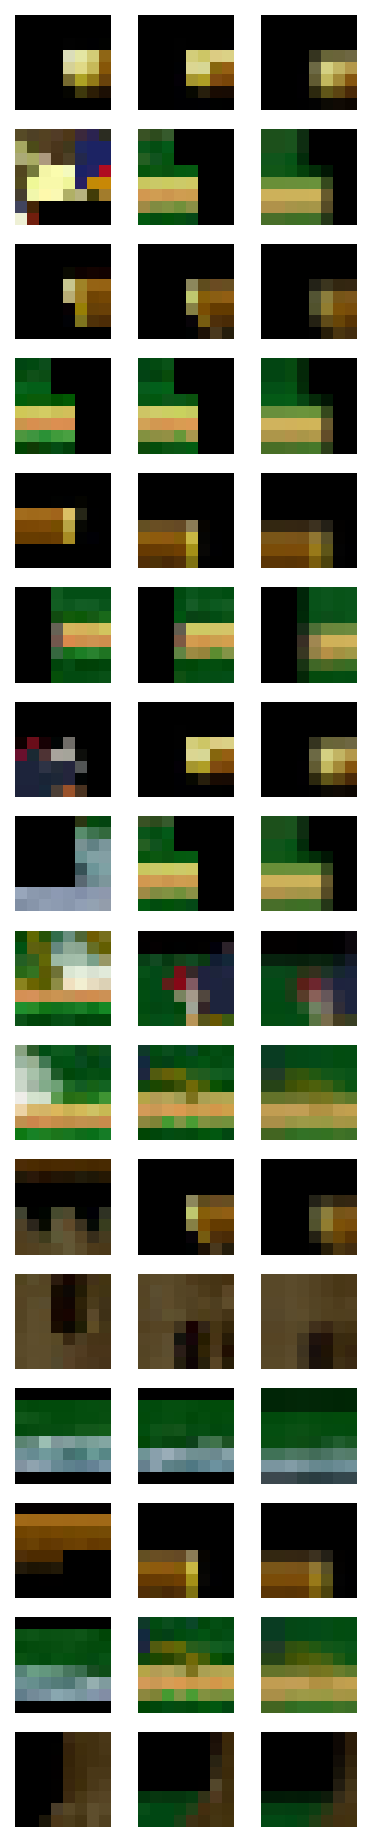

In [22]:
frame_num = 20
frameA = downscale_and_mask( grab_frame(frame_num, clip) )
frameB = downscale_and_mask( grab_frame(frame_num+5, clip) )
compare_frames(frameA, frameB)

#### I should ignore kps around the masked regions
___

#### inflate mask by small %, or add like 1or2px border to masked regions and call that kps_ignoring_mask

In [62]:
# help set up binary descriptors
def new_pt_in_2d_std_dist(mean, std_dev, lower, upper):
    x, y = np.random.normal(mean, std_dev, 2)
    x, y = int(round(x)), int(round(y))
    if (x >= lower and x < upper and
        y >= lower and y < upper):
        return x, y
    else:
        return new_pt_in_2d_std_dist(mean, std_dev, lower, upper)

In [64]:
# help set up binary descriptors
def random_sample_pairs_in_radius(radius, num_pairs):
    # generate sampling pairs.
    # only needs to be called once to get static pt pairs for all future tests
    # normal(gaussian) distr clusters in circular center of patch
    # num_points should be less than num pixels in patch, (2*radius)**2
    lower = 0
    upper = 2*radius
    mean = radius
    std_dev = radius / 3    # distr within +-3 std deviations
                            # 0.3% chance it will be outside of radius
    pairs = []
    while len(pairs) < num_pairs:
        pt1 = new_pt_in_2d_std_dist(mean, std_dev, lower, upper)
        pt2 = new_pt_in_2d_std_dist(mean, std_dev, lower, upper)
        while pt1 == pt2:
            pt2 = new_pt_in_2d_std_dist(mean, std_dev, lower, upper)

        if ((pt1, pt2) not in pairs and
            (pt2, pt1) not in pairs):
            pairs.append((pt1, pt2))
            
    return pairs

descriptor_generating_pairs = random_sample_pairs_in_radius(PATCH_RADIUS, num_pairs=256)

In [65]:
def describe_patch(patch):
    # returns binary descriptor
    patch = to_grayscale(patch)  # maybe room to change it up here? eg use y-channel from YCrCb
    patch = blur(patch)
    bit_str = b''
    for pt1, pt2 in descriptor_generating_pairs:  # premade gaussian pt distribution
        if patch[pt1] > patch[pt2]:         # gets (y, x) but doesn't matter, still random
            bit_str += b'1'
        else:
            bit_str += b'0'            
    return bit_str

In [66]:
def compare_descriptors(byte_str1, byte_str2):
    # uses hamming dist on binary descriptors
    differences = 0
    for bit1, bit2 in zip(byte_str1, byte_str2):
        differences += bit1 ^ bit2  # python can only bitwise operate on ints from byte str,
    return differences              #   not bits from bit string sadly

In [73]:
for kp in kpsB:
    pt = kp['pt']
#     i = nearest_pts_indexes(pt, ptsA)[0]
    patchB = kp['patch']
#     patchA = kpsA[i]['patch']
    desB = describe_patch(patchA)
#     desA = describe_patch(patchB)
#     score = compare_descriptors(patchB, patchA)
    scores = []
    for i in nearest_pts_indexes(pt, ptsA):
        patchA = kpsA[i]['patch']
        desA = describe_patch(patchA)
        scores.append(compare_descriptors(desB, desA))
    print(scores)
        

[138, 45, 71, 59, 119, 139, 0, 110, 131, 158, 53, 137, 156, 126, 108, 74]
[65, 95, 140, 161, 150, 97, 0, 184, 161, 172, 88, 87, 83, 166, 157, 74]
[131, 110, 119, 71, 53, 138, 45, 59, 126, 137, 158, 74, 139, 156, 108, 0]
[71, 138, 119, 45, 131, 110, 59, 53, 139, 158, 0, 137, 126, 156, 74, 108]
[209, 208, 0, 88, 111, 142, 200, 105, 77, 168, 179, 119, 197, 135, 208, 108]
[59, 158, 45, 139, 119, 53, 137, 138, 156, 71, 110, 0, 108, 74, 126, 131]
[109, 144, 53, 42, 62, 197, 114, 122, 178, 161, 131, 41, 49, 75, 102, 0]
[49, 161, 122, 42, 197, 75, 53, 178, 109, 0, 144, 114, 102, 62, 41, 131]
[74, 108, 137, 126, 156, 53, 158, 59, 119, 110, 139, 45, 131, 71, 138, 0]
[156, 137, 108, 158, 74, 59, 53, 126, 139, 119, 45, 110, 138, 0, 71, 131]
[75, 178, 0, 122, 102, 49, 144, 42, 114, 41, 109, 161, 53, 197, 62, 131]
[139, 59, 158, 0, 45, 138, 156, 137, 119, 71, 53, 108, 110, 74, 126, 131]
[131, 62, 114, 41, 144, 109, 102, 178, 53, 42, 122, 75, 197, 0, 161, 49]
[121, 149, 44, 73, 91, 163, 108, 126, 113